In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import ROOT
import uproot 
import awkward as ak
from pathlib import Path
import os
from tqdm import tqdm

Welcome to JupyROOT 6.24/00


In [9]:
def Get_ind_best_reco_HS_sum_pt2(reco_tree_arrays, i_event, reco_type):
    # Return the index of the best reconstructed HS via sum of pt^2 method 
    trk_pt_sq = ((1./reco_tree_arrays["reco_vtx_fitted_trk_qp"][i_event])*np.sin(reco_tree_arrays["reco_vtx_fitted_trk_theta"][i_event]) )**2
    if reco_type=="spvcnn":
        n_vtx = len(reco_tree_arrays["refitted_avg_vtx_vz"][i_event])
    elif reco_type=="weighted":
        n_vtx = len(reco_tree_arrays["refitted_weighted_vtx_vz"][i_event])
    else:
        n_vtx = len(reco_tree_arrays["reco_vtx_vz"][i_event])
            
    vtx_trk_pt_sq_sum = np.zeros(n_vtx)
    for i in range(n_vtx):
        vtx_trk_pt_sq_sum[i] = ak.sum(trk_pt_sq[reco_tree_arrays["reco_vtx_fitted_trk_vtxID"][i_event] == i])
    
#     print(vtx_trk_pt_sqrt_sum)
    
    return vtx_trk_pt_sq_sum.argmax()



In [10]:
def Get_local_PU_density(truth_tree_arrays, i_event, xyz_dist_window = 2.0):
    # Calculate the PU density around the truth HS vertex 
    truth_vtx_vx = truth_tree_arrays["truth_vtx_vx"][i_event]
    truth_vtx_vy = truth_tree_arrays["truth_vtx_vy"][i_event]
    truth_vtx_vz = truth_tree_arrays["truth_vtx_vz"][i_event]
    
    dist_to_truth_HS = (truth_vtx_vx - truth_vtx_vx[0])**2 +(truth_vtx_vy - truth_vtx_vy[0])**2 + (truth_vtx_vz - truth_vtx_vz[0])**2 
    n_local_truth = len(np.where(dist_to_truth_HS< 2.0**2)[0])
    return (n_local_truth - 1)/(2 * xyz_dist_window)

In [2]:
SPVCNN_file_path = "../SPVCNN_outputs_refitted.root"
spvcnn_tree_arrays = uproot.open(SPVCNN_file_path)["refitted_avg"].arrays()


file_path = "/home/dejavu/Projects/vertexing_sample/vertexperformance_AMVF_pu10.root"
truth_tree_arrays = uproot.open(file_path)["Truth_Vertex_PV_Selected"].arrays()
reco_tree_arrays = uproot.open(file_path)["Reco_Vertex"].arrays()


In [14]:
canvas = ROOT.TCanvas()
hs_reco_eff = ROOT.TEfficiency("hs_reco_eff", "HS Reconstruction Efficiency; Local PU density; eff", 12, 0, 6)
hs_sel_eff = ROOT.TEfficiency("hs_sel_eff", "HS selection and Reconstruction Efficiency; Local PU density; eff", 12, 0, 6)

hs_truth_long_reso_vs_PU = ROOT.TH2D("hs_truth_long_reso_vs_PU", "HS Longitudinal Resolution vs PU density; Local PU density; [mm]", 12, 0, 6.0, 20, -0.08, 0.08);


whole_match_matrix = []
# In the future, whole_match_matrix will be used to classify 
# for i_event in range(len(reco_tree_arrays["event_id"])):
for i_event in tqdm(spvcnn_tree_arrays.event_id):
    
    truth_vtx_vz = truth_tree_arrays["truth_vtx_vz"][i_event]
    reco_vtx_vz = reco_tree_arrays["reco_vtx_vz"][i_event]
    match_matrix = np.zeros((len(reco_vtx_vz),len(truth_vtx_vz)))
    # declare the truth-mathing matrix as a list, filled in the next 2 loops 
    # Can be normalized 

    for i in range(len(reco_vtx_vz)):
        for j in range(len(truth_vtx_vz)):
            test_reco = reco_tree_arrays["reco_vtx_fitted_trk_z0"][i_event][reco_tree_arrays["reco_vtx_fitted_trk_vtxID"][i_event] == i]
            test_truth = truth_tree_arrays["truth_vtx_fitted_trk_z0"][i_event][truth_tree_arrays["truth_vtx_fitted_trk_vtxID"][i_event] == j]
            match_matrix[i,j] = len(np.intersect1d(test_reco, test_truth))
            
    whole_match_matrix.append(match_matrix)
    
    
    # Find the index of best reco HS via 2 ways 
    ind_best_reco_HS_nTrk = match_matrix[:,0].argmax()
    ind_best_reco_HS_sumpt2 = Get_ind_best_reco_HS_sum_pt2(reco_tree_arrays, i_event, "reco")
    
    # dist_best_reco_to_truth_HS_sq = (reco_tree_arrays["reco_vtx_vx"][i_event][ind_best_reco_HS_nTrk] - truth_tree_arrays["truth_vtx_vx"][i_event][0])**2 + (reco_tree_arrays["reco_vtx_vy"][i_event][ind_best_reco_HS_nTrk] - truth_tree_arrays["truth_vtx_vy"][i_event][0])**2 + (reco_tree_arrays["reco_vtx_vz"][i_event][ind_best_reco_HS_nTrk] - truth_tree_arrays["truth_vtx_vz"][i_event][0])**2 
    residual_z = reco_tree_arrays["reco_vtx_vz"][i_event][ind_best_reco_HS_nTrk] - truth_tree_arrays["truth_vtx_vz"][i_event][0]
    residual_x = reco_tree_arrays["reco_vtx_vx"][i_event][ind_best_reco_HS_nTrk] - truth_tree_arrays["truth_vtx_vx"][i_event][0]
    residual_y = reco_tree_arrays["reco_vtx_vy"][i_event][ind_best_reco_HS_nTrk] - truth_tree_arrays["truth_vtx_vy"][i_event][0]
    
    dist_best_reco_to_truth_HS_sq =  residual_z**2 + residual_x**2 + residual_y**2
    trhth_HS_vtx_recoed = False
    if dist_best_reco_to_truth_HS_sq < (0.1 ** 2):
        trhth_HS_vtx_recoed = True

    trhth_HS_vtx_seled = (bool)(ind_best_reco_HS_nTrk == ind_best_reco_HS_sumpt2)

    
    local_PU_density = Get_local_PU_density(truth_tree_arrays, i_event)
    hs_reco_eff.Fill(trhth_HS_vtx_recoed, local_PU_density)
    hs_sel_eff.Fill(trhth_HS_vtx_recoed and trhth_HS_vtx_seled, local_PU_density)
    if trhth_HS_vtx_recoed:
        hs_truth_long_reso_vs_PU.Fill(local_PU_density, residual_z)


100%|██████████| 1000/1000 [01:01<00:00, 16.17it/s]
Warning in <TROOT::Append>: Replacing existing TH1: hs_truth_long_reso_vs_PU (Potential memory leak).


In [40]:
canvas = ROOT.TCanvas()
spvcnn_hs_reco_eff = ROOT.TEfficiency("spvcnn_hs_reco_eff", "HS Reconstruction Efficiency; Local PU density; eff", 12, 0, 6)
spvcnn_hs_sel_eff = ROOT.TEfficiency("spvcnn_hs_sel_eff", "HS selection and Reconstruction Efficiency; Local PU density; eff", 12, 0, 6)

spvcnn_hs_truth_long_reso_vs_PU = ROOT.TH2D("spvcnn_hs_truth_long_reso_vs_PU", "HS Longitudinal Resolution vs PU density; Local PU density; [mm]", 12, 0, 6.0, 20, -0.08, 0.08);


spvcnn_whole_match_matrix = []
# In the future, whole_match_matrix will be used to classify 
# for i_event in range(len(spvcnn_tree_arrays["event_id"])):
for ii, i_event in tqdm(enumerate(spvcnn_tree_arrays.event_id)):
    
    truth_vtx_vz = truth_tree_arrays["truth_vtx_vz"][i_event]
    reco_vtx_vz = spvcnn_tree_arrays["refitted_avg_vtx_vz"][ii]
    match_matrix = np.zeros((len(reco_vtx_vz),len(truth_vtx_vz)))
    # declare the truth-mathing matrix as a list, filled in the next 2 loops 
    # Can be normalized 

    for i in range(len(reco_vtx_vz)):
        for j in range(len(truth_vtx_vz)):
            test_reco = spvcnn_tree_arrays["reco_vtx_fitted_trk_z0"][ii][spvcnn_tree_arrays["reco_vtx_fitted_trk_vtxID"][ii] == i]
            test_truth = truth_tree_arrays["truth_vtx_fitted_trk_z0"][i_event][truth_tree_arrays["truth_vtx_fitted_trk_vtxID"][i_event] == j]
            match_matrix[i,j] = len(np.intersect1d(test_reco, test_truth))
            
    spvcnn_whole_match_matrix.append(match_matrix)
    
    
    # Find the index of best reco HS via 2 ways 
    ind_best_reco_HS_nTrk = match_matrix[:,0].argmax()
    ind_best_reco_HS_sumpt2 = Get_ind_best_reco_HS_sum_pt2(spvcnn_tree_arrays, ii, "spvcnn")
    
    # dist_best_reco_to_truth_HS_sq = (spvcnn_tree_arrays["reco_vtx_vx"][i_event][ind_best_reco_HS_nTrk] - truth_tree_arrays["truth_vtx_vx"][i_event][0])**2 + (spvcnn_tree_arrays["reco_vtx_vy"][i_event][ind_best_reco_HS_nTrk] - truth_tree_arrays["truth_vtx_vy"][i_event][0])**2 + (spvcnn_tree_arrays["reco_vtx_vz"][i_event][ind_best_reco_HS_nTrk] - truth_tree_arrays["truth_vtx_vz"][i_event][0])**2 
    residual_z = spvcnn_tree_arrays["refitted_avg_vtx_vz"][ii][ind_best_reco_HS_nTrk] - truth_tree_arrays["truth_vtx_vz"][i_event][0]
    residual_x = spvcnn_tree_arrays["refitted_avg_vtx_vx"][ii][ind_best_reco_HS_nTrk] - truth_tree_arrays["truth_vtx_vx"][i_event][0]
    residual_y = spvcnn_tree_arrays["refitted_avg_vtx_vy"][ii][ind_best_reco_HS_nTrk] - truth_tree_arrays["truth_vtx_vy"][i_event][0]
    
    dist_best_reco_to_truth_HS_sq =  residual_z**2 + residual_x**2 + residual_y**2
    trhth_HS_vtx_recoed = False
    if dist_best_reco_to_truth_HS_sq < (0.1 ** 2):
        trhth_HS_vtx_recoed = True

    trhth_HS_vtx_seled = (bool)(ind_best_reco_HS_nTrk == ind_best_reco_HS_sumpt2)

    
    local_PU_density = Get_local_PU_density(truth_tree_arrays, i_event)
    spvcnn_hs_reco_eff.Fill(trhth_HS_vtx_recoed, local_PU_density)
    spvcnn_hs_sel_eff.Fill(trhth_HS_vtx_recoed and trhth_HS_vtx_seled, local_PU_density)
    if trhth_HS_vtx_recoed:
        spvcnn_hs_truth_long_reso_vs_PU.Fill(local_PU_density, residual_z)

1000it [01:01, 16.21it/s]


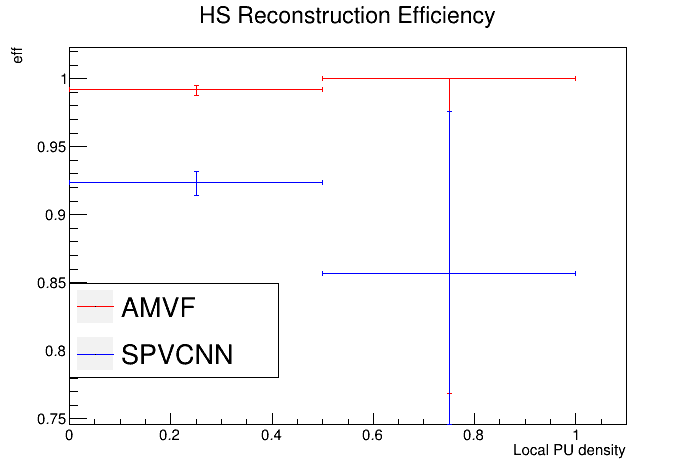

In [38]:
canvas_reco_eff = ROOT.TCanvas()
legend_reco_eff = ROOT.TLegend(0.1,0.2,0.4,0.4)

hs_reco_eff.SetLineColor(2)
hs_reco_eff.Draw()

spvcnn_hs_reco_eff.SetLineColor(4)
spvcnn_hs_reco_eff.Draw("same")

legend_reco_eff.AddEntry(hs_reco_eff, "AMVF")
legend_reco_eff.AddEntry(spvcnn_hs_reco_eff, "SPVCNN")

legend_reco_eff.Draw("same")
canvas_reco_eff.Draw()

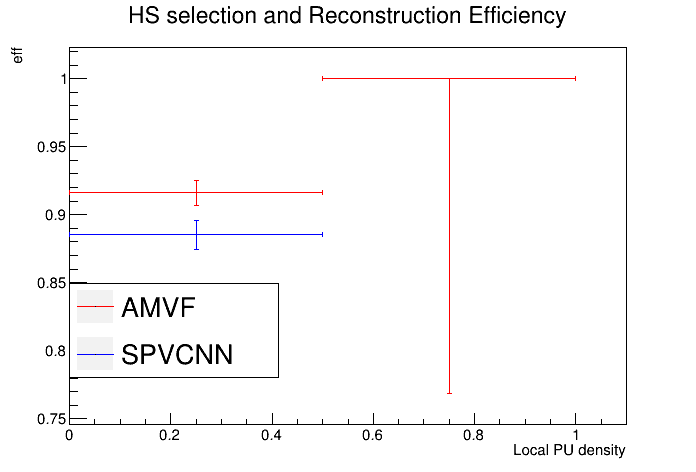

In [39]:
canvas_sel_eff = ROOT.TCanvas()
legend_sel_eff = ROOT.TLegend(0.1,0.2,0.4,0.4)

hs_sel_eff.SetLineColor(2)
hs_sel_eff.Draw()

spvcnn_hs_sel_eff.SetLineColor(4)
spvcnn_hs_sel_eff.Draw("same")

legend_sel_eff.AddEntry(hs_sel_eff, "AMVF")
legend_sel_eff.AddEntry(spvcnn_hs_sel_eff, "SPVCNN")
legend_sel_eff.Draw("same")
canvas_sel_eff.Draw()

In [61]:
whole_match_matrix[0]

array([[67.,  0.,  0.,  0.],
       [ 0.,  4.,  0.,  0.],
       [ 0.,  0.,  7.,  0.],
       [ 0.,  0.,  0.,  2.],
       [ 5.,  0.,  0.,  0.]])

In [ ]:
spvcnn_whole_match_matrix[0]
whole_match_matrix[0]
spvcnn_tree_arrays["refitted_avg_vtx_vz"][0]
reco_tree_arrays["reco_vtx_vz"][19]
truth_tree_arrays["truth_vtx_vz"][19]